In [1]:
# following codes were tested with Anaconda environment online.

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from platform import python_version

print(python_version())

3.7.4


In [3]:
keras.__version__

'2.5.0'

In [4]:
tf.__version__

'2.5.0-dev20201129'

In [5]:
img_height=400
img_width=518
batch_size=32

In [6]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(
    './data',labels='inferred',label_mode='int',
    validation_split=0.2, subset='training',
    seed=123,color_mode='grayscale',
    image_size=(img_height,img_width),
    batch_size=batch_size
    )

Found 280 files belonging to 2 classes.
Using 224 files for training.


In [7]:
val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    './data',labels='inferred',label_mode='int',
    validation_split=0.2, subset='validation',
    seed=123,color_mode='grayscale',
    image_size=(img_height,img_width),
    batch_size=batch_size
    )

Found 280 files belonging to 2 classes.
Using 56 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['par1', 'wt']


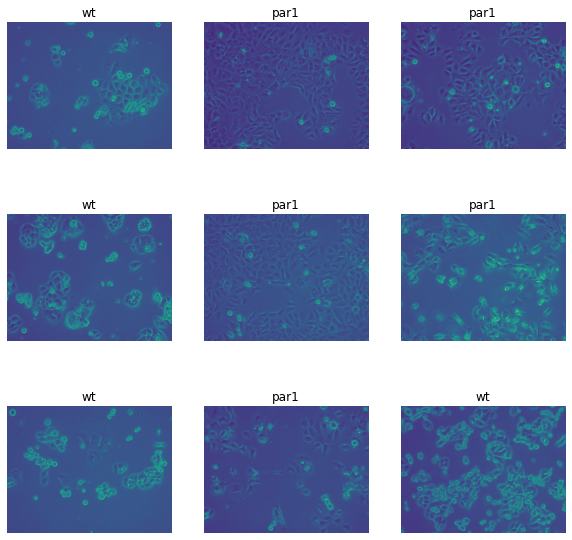

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

for images,labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 400, 518, 1)
(32,)


In [11]:
# Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. 
# These are two important methods you should use when loading data.

# Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. 
# This will ensure the dataset does not become a bottleneck while training your model. 
# If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk 
# cache.

# Dataset.prefetch() overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# This is for normalization foorr RBG channel. We used Grayscale, so search whether this is required 
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [126]:
# Create the model (Note that below model does not contain drop out)

num_classes = 2

# model = Sequential([
#   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'), 
#   layers.Dense(num_classes)
# ])

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [127]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [128]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_16 (Rescaling)     (None, 400, 518, 1)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 400, 518, 32)      320       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 200, 259, 32)      0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 200, 259, 64)      18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 100, 129, 64)      0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 100, 129, 128)     73856     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 50, 64, 128)     

In [129]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
7/7 [==============================] - 22s 3s/step - loss: 3.0017 - accuracy: 0.5388 - val_loss: 0.7495 - val_accuracy: 0.3571
Epoch 2/15
7/7 [==============================] - 21s 3s/step - loss: 0.6853 - accuracy: 0.5397 - val_loss: 0.7252 - val_accuracy: 0.3571
Epoch 3/15
7/7 [==============================] - 21s 3s/step - loss: 0.6825 - accuracy: 0.5469 - val_loss: 0.6932 - val_accuracy: 0.3571
Epoch 4/15
7/7 [==============================] - 21s 3s/step - loss: 0.6772 - accuracy: 0.5492 - val_loss: 0.8254 - val_accuracy: 0.3571
Epoch 5/15
7/7 [==============================] - 21s 3s/step - loss: 0.6900 - accuracy: 0.5119 - val_loss: 0.7572 - val_accuracy: 0.3571
Epoch 6/15
7/7 [==============================] - 21s 3s/step - loss: 0.6340 - accuracy: 0.5672 - val_loss: 0.6307 - val_accuracy: 0.6607
Epoch 7/15
7/7 [==============================] - 21s 3s/step - loss: 0.5826 - accuracy: 0.7257 - val_loss: 0.6593 - val_accuracy: 0.5714
Epoch 8/15
7/7 [==================

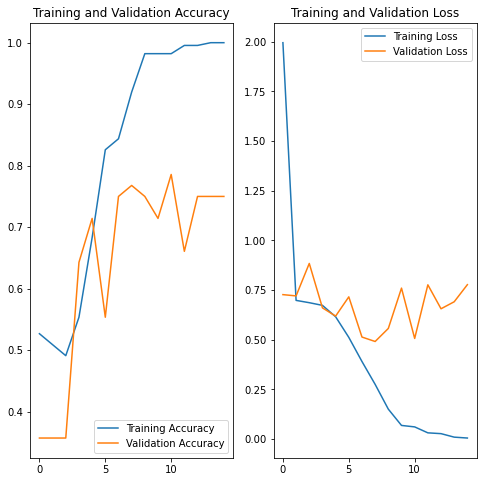

In [105]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [106]:
# Above graph indicates the sign of overfitting. Let's increase the dataset by augmentation

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal",
                                                    input_shape=(img_height,img_width,1)),
        layers.experimental.preprocessing.RandomRotation(0.1)
    ]
)

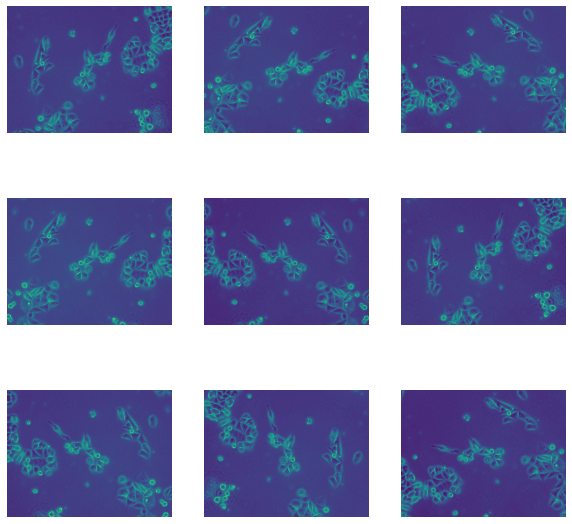

In [107]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax=plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [121]:
# Also, dropout technique helps reduce overfitting

model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
#     layers.Dropout(0.5), # newly added
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
#     layers.Dropout(0.5), # newly added
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2), # so far, 0.3 worked well
    layers.Flatten(),
    layers.Dense(64, activation='relu'), # or softmax # decreasing this layer no. causes overfitting?
    layers.Dense(num_classes)
    
])

# test with more filters : 32-64-128
# model = Sequential([
#     data_augmentation,
#     layers.experimental.preprocessing.Rescaling(1./255),
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
# #     layers.Dropout(0.5), # newly added
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
# #     layers.Dropout(0.5), # newly added
#     layers.Conv2D(128, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.2), # so far, 0.3 worked well
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'), # or softmax
#     layers.Dense(num_classes)
    
# ])

# perhaps we need smaller dense layer? (ucohead used 32)

In [122]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [123]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_15 (Sequential)   (None, 400, 518, 1)       0         
_________________________________________________________________
rescaling_15 (Rescaling)     (None, 400, 518, 1)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 400, 518, 16)      160       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 200, 259, 16)      0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 200, 259, 32)      4640      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 100, 129, 32)      0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 100, 129, 64)    

In [124]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
7/7 [==============================] - 12s 2s/step - loss: 1.8585 - accuracy: 0.5062 - val_loss: 0.9178 - val_accuracy: 0.3571
Epoch 2/15
7/7 [==============================] - 11s 2s/step - loss: 0.7199 - accuracy: 0.5263 - val_loss: 0.6964 - val_accuracy: 0.3571
Epoch 3/15
7/7 [==============================] - 11s 2s/step - loss: 0.6840 - accuracy: 0.5339 - val_loss: 0.7330 - val_accuracy: 0.3571
Epoch 4/15
7/7 [==============================] - 11s 2s/step - loss: 0.6784 - accuracy: 0.5236 - val_loss: 0.6950 - val_accuracy: 0.3571
Epoch 5/15
7/7 [==============================] - 11s 2s/step - loss: 0.6634 - accuracy: 0.5279 - val_loss: 0.6782 - val_accuracy: 0.7321
Epoch 6/15
7/7 [==============================] - 11s 2s/step - loss: 0.6675 - accuracy: 0.6540 - val_loss: 0.7634 - val_accuracy: 0.3571
Epoch 7/15
7/7 [==============================] - 11s 2s/step - loss: 0.6400 - accuracy: 0.6222 - val_loss: 0.7903 - val_accuracy: 0.3571
Epoch 8/15
7/7 [==================

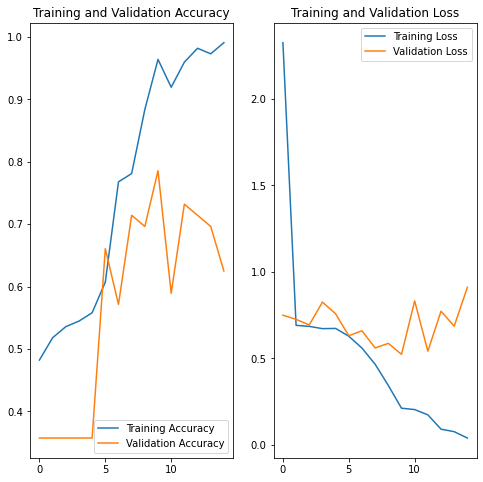

In [130]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [115]:
img = keras.preprocessing.image.load_img(
#     './test_images/par1_early_008.jpg', 
    './test_images/wt_early_017.jpg', 
    color_mode='grayscale', target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to wt with a 51.49 percent confidence.
